## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Techinasia Cohort Analysis

In [22]:
data_2 = pd.read_csv('D:\BERKAS  MASDAR\Project Machine Learning\TechinAsia - Test\Fingerprint.csv')

C:\Users\user\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df2 = data_2.copy()
df2 = df2[['timestamp', 'load_at', 'ip', 'fingerprint']].drop_duplicates()
df2

,timestamp,load_at,ip,fingerprint
0,2020-03-09 06:25:20.218,2020-03-16 04:20:52.166128+00,115.178.250.204,2dc2d3a9934b9675dc6358a37276eb7e
1,2020-03-09 06:25:20.656,2020-03-16 04:20:52.220083+00,112.215.66.229,35d0b10bb802e312ed901eb998369ccf
2,2020-03-09 06:25:48.324,2020-03-16 04:20:52.256077+00,65.57.245.11,2dc2d3a9934b9675dc6358a37276eb7e
3,2020-03-09 06:25:54.532,2020-03-16 04:20:52.292594+00,3.223.195.185,8e45b660fb3ab2b7dfc21c36a8a87801
4,2020-03-09 06:26:49.331,2020-03-16 04:20:52.330136+00,180.252.219.10,7ef6a995a105561bb680eeb80554b9ae
...,...,...,...,...
2586094,2020-08-10 06:07:23.354,2020-08-10 06:32:03.860507+00,175.158.38.97,0e5ec161dbb61a63cb0f93f9e3e3b20e
2586095,2020-08-10 06:07:28.182,2020-08-10 06:32:03.896772+00,36.84.147.50,1b2dd7c90a336f19dede7a8d31031d7a
2586096,2020-08-10 06:07:29.378,2020-08-10 06:32:03.936796+00,36.70.183.92,0769f23c054e3fd40dcbabfe626fa42d
2586097,2020-08-10 06:07:31.383,2020-08-10 06:32:03.972886+00,43.252.106.202,b507ef6fc201ae8b204851c5ad8781d0


In [24]:
# create two variables: month of order and cohort
df2['time_new'] = pd.to_datetime(df2['timestamp'])

df2['order_month'] = df2['time_new'].dt.to_period('M')
df2['cohort'] = df2.groupby('ip')['time_new'] \
                 .transform('min') \
                 .dt.to_period('M')


In [25]:
df2['order_month'] - df2['order_month']

0          <0 * MonthEnds>
1          <0 * MonthEnds>
2          <0 * MonthEnds>
3          <0 * MonthEnds>
4          <0 * MonthEnds>
                ...       
2586094    <0 * MonthEnds>
2586095    <0 * MonthEnds>
2586096    <0 * MonthEnds>
2586097    <0 * MonthEnds>
2586098    <0 * MonthEnds>
Name: order_month, Length: 2586099, dtype: object

In [26]:
# add an indicator for periods (months since first purchase)
df_cohort2 = df2.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('ip', 'nunique')) \
              .reset_index(drop=False)

In [27]:
df_cohort2['period_number'] = (df_cohort2.order_month - df_cohort2.cohort).apply(attrgetter('n'))

In [28]:
# pivot the data into a form of the matrix
cohort_pivot2 = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [29]:
# divide by the cohort size (month 0) to obtain retention as %
cohort_size2 = cohort_pivot2.iloc[:,0]
retention_matrix2 = cohort_pivot2.divide(cohort_size2, axis = 0)
retention_matrix2

period_number,0,1,2,3,4,5
cohort,,,,,,
2020-03,1.0,0.468188,0.292579,0.285702,0.263849,0.101015
2020-04,1.0,0.140792,0.135965,0.133081,0.043571,NaN
2020-05,1.0,0.116321,0.102789,0.037821,NaN,NaN
2020-06,1.0,0.108493,0.036965,NaN,NaN,NaN
2020-07,1.0,0.039377,NaN,NaN,NaN,NaN
2020-08,1.0,NaN,NaN,NaN,NaN,NaN


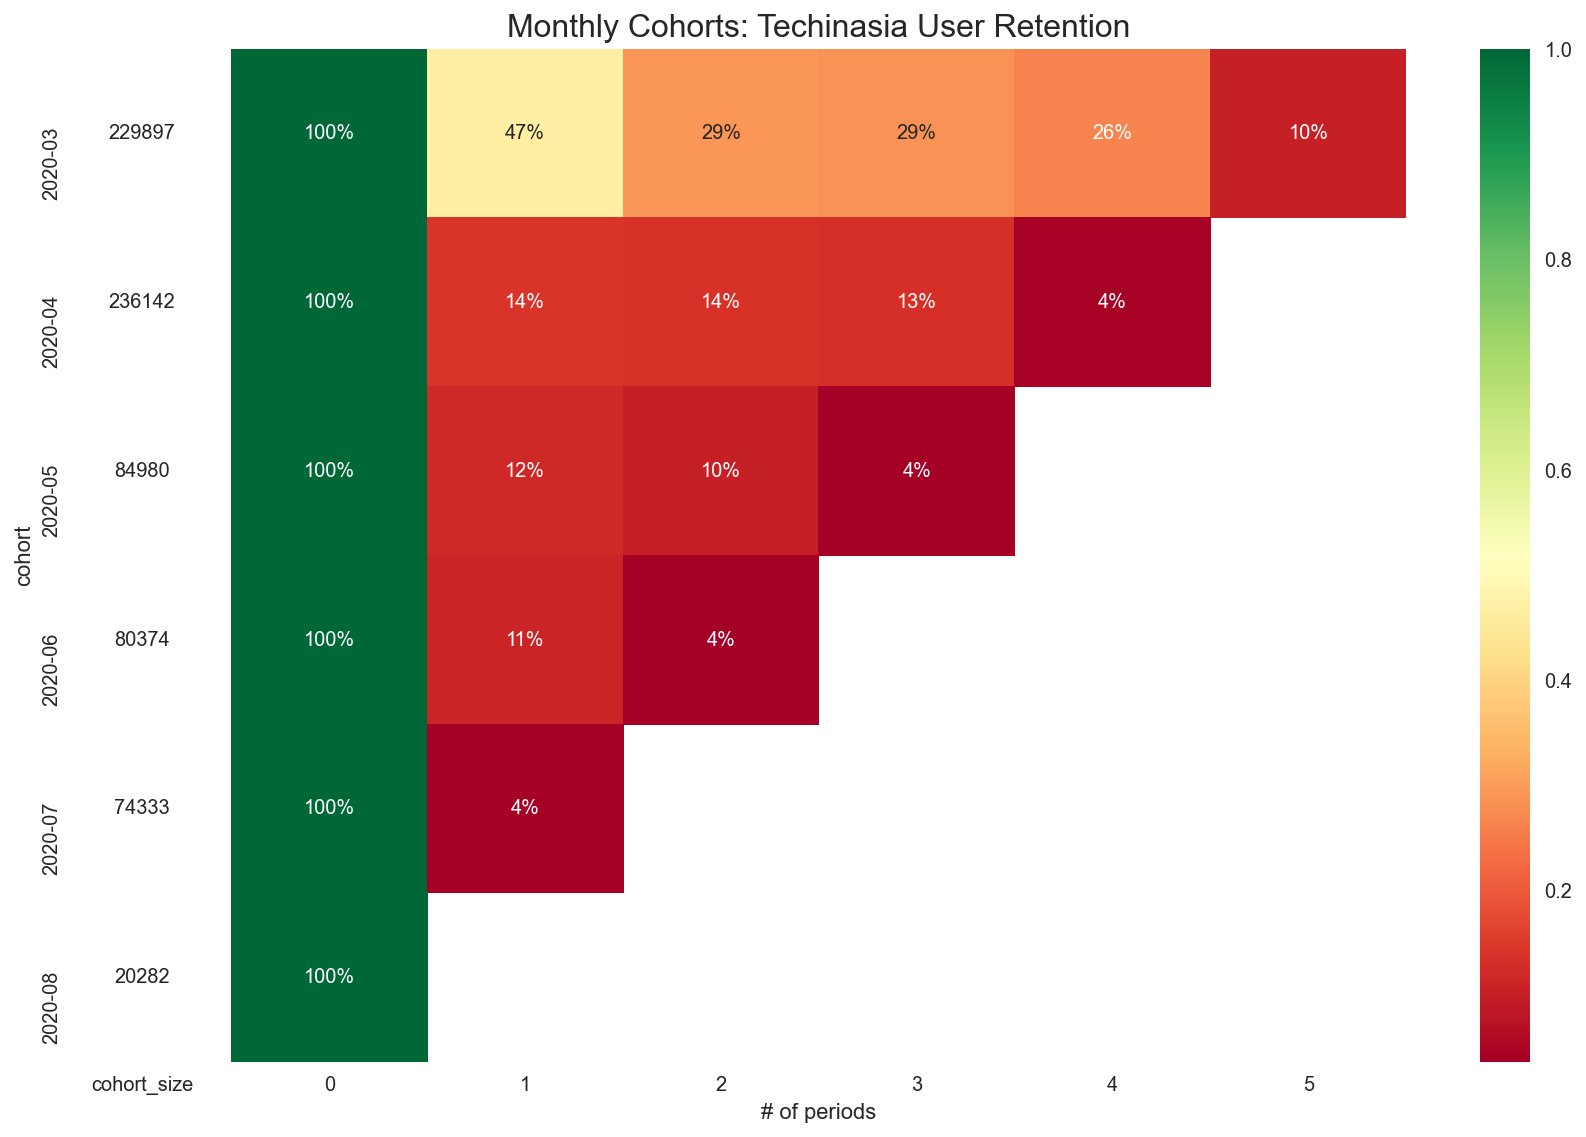

In [31]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
      
    # retention matrix
    sns.heatmap(retention_matrix2, 
                mask=retention_matrix2.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Techinasia User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size2).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Cohort Analysis ini bertujuan untuk mengamati User retention dalam periode waktu Maret 2020 hingga Agustus 2020. Data User diambil dari alammat ip user dan jumlah kunjungan ke website techinasia dalam setiap bulan. 

Didapatkan insight, bahwa user retention cukup rendah. Hal ini dikomparasikan dengan EDA data fingerprint.csv yang menunjukkan pengunjung website Techinasia cenderung menurun dari bulan Maret hingga Agustus. Indikasi penebab penurunan ini adalah Artikel yang dimuat pada halaman Techinasia kurang menarik bagi pembaca.

Berdasarkan data di EDA, didapatkan insight bahwa artikel yang menarik bagi pembaca adalah artikel seputar 'StartUp' yang berkaitan dengan 'Industry Insight'. Jadi, disarankan untuk kedepannya Techinasia lebih banyak menulis artikel seputar StartUp dalam sudut pandang Industri.

By Masdar.